In [1]:
%reload_ext autoreload
%autoreload 2

In [283]:
import os
import numpy as np
import pandas as pd
from linescanning import *
from linescanning.glm import plot_array
from linescanning.pycortex import set_ctx_path
import json
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Polygon
import pyreadstat
import cortex
from linescanning.bin.utils.utils import format_graph, errorfill
from scipy.stats import sem
from sklearn.metrics import auc
import pandas as pd
import seaborn as sns
import pickle
import sympy as sy
pd.options.mode.chained_assignment = None
opj = os.path.join

In [412]:
PROJECT = "URIS-MDD"
base,place = utils.get_base_dir()

proj = opj(base, 'projects', PROJECT)
fs_dir = opj(proj, 'derivatives','freesurfer')
nighres_dir = opj(proj, 'derivatives','nighres')
ctx_dir = opj(proj, 'derivatives','pycortex')

mask_dir = opj(proj, 'derivatives','manual_masks')

# g1.plot(all_data[[step], color=rois['ROI'][i]['color'])
mdd_color = "#08B2F0"
con_color = "#cccccc"

# MUST MATCH ORDER IN ROI.JSON
roi_list = ['rACC','mOFC','lPFC']
# roi_list = [f'{hemi}_{i}' for i in roi_list for hemi in ['lh','rh']]
roi_list

['rACC', 'mOFC', 'lPFC']

In [5]:
# update pycortex directory
set_ctx_path(p=ctx_dir, opt="update")

ff = cortex.options.userdir
! cat $ff/options.cfg

[basic]
default_cmap = RdBu_r
default_cmap2d = RdBu_covar
fsl_prefix = 
filestore = /data1/projects/MicroFunc/Jurjen/projects/URIS-MDD/derivatives/pycortex

[dependency_paths]
inkscape = inkscape
blender = blender
slim = None
meshlab = None

[mayavi_aligner]
line_width = 1
point_size = 2
outline_color = white
outline_rep = wireframe
opacity = 0
colormap = gray

[paths_default]
stroke = white
fill = none
display = inline
filter = url(#dropshadow)
stroke-width = 3
stroke-opacity = 1
fill-opacity = 0
stroke-dashoffset = None
stroke-dasharray = None

[labels_default]
font-family = Helvetica, sans-serif
font-size = 18pt
font-weight = bold
font-style = italic
fill = white
fill-opacity = 1
text-anchor = middle
filter = url(#dropshadow)

[overlay_paths]
stroke = white
fill = none
display = inline
filter = url(#dropshadow)
stroke-width = 2
stroke-opacity = 1
fill-opacity = 0
stroke-dashoffset = None
stroke-dasharray = None

[overlay_text]
font-family = Helvetica, sans-serif
font-size = 14pt
fon

---
# Plot T1map on surface

In [7]:
import glob

pname = opj(fs_dir, 'fsaverage', 'volumes')
surf_list = glob.glob(pname+'/*T1map.npy')
print(len(surf_list))

surf_avg = []
for file in surf_list:
    surf_avg.append(np.load(file)[...,np.newaxis])

surf_data = np.concatenate(surf_avg, axis=-1)
surf_avg = surf_data.mean(axis=-1)
surf_std = surf_data.std(axis=-1)

surf_avg_v = cortex.Vertex(surf_avg, subject='fsaverage', vmin=1500, vmax=2000, cmap='viridis')
surf_std_v = cortex.Vertex(surf_std, subject='fsaverage', cmap='viridis')

62


In [6]:
cortex.webshow(surf_avg_v)

Started server on port 56063


<JS: window.viewer>

Stopping server


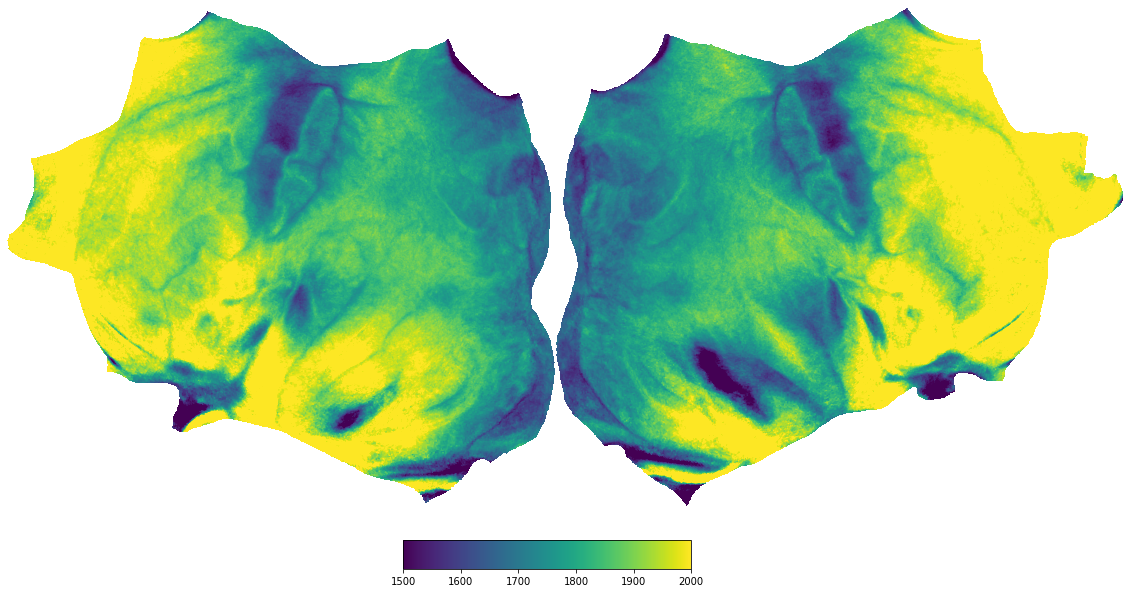

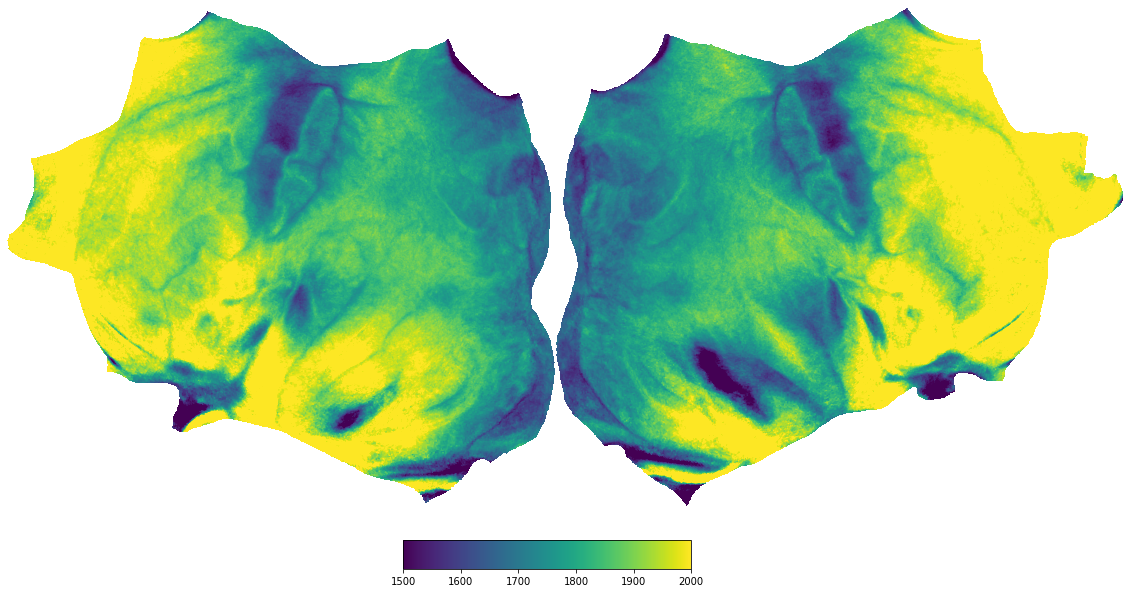

In [8]:
fig,axs = plt.subplots(figsize=(20,10))

cortex.quickshow(surf_avg_v, with_colorbar=True, with_rois=False, with_sulci=False, with_labels=True, with_curvature=True, fig=axs)

---
# Actual analysis

In [9]:
subj_list = pd.read_csv(opj(proj, 'participants.tsv'), delimiter='\t')

# for num,sub in enumerate(subj_list['participant_id'].values):
#     print(subj_list['group'][num])

In [250]:
# clinical data
clinData = opj(opj(proj), 'code', 'clinical')
clinItems = sorted(os.listdir(clinData))

includeClinItems = ['UR_102', 'UR_104', 'UR_105']


In [413]:
demo_info = pd.read_spss(opj(proj, 'UR_001.sav')).set_index(['ID'])
demo_info.reset_index()
full_data = demo_info.reset_index().copy()
full_data

# load in clinical data
for clin in includeClinItems:

    if clin == "UR_102":
        incl_cols = ['pident', 'med0', 'med0a']
    elif clin == "UR_104":
        incl_cols = ['Pident', 'mddids', 'mddidssev', 'ids', 'idssev']
    elif clin == "UR_105":
        incl_cols = ['Pident', 'MDDBAIscal', 'BAImis', 'BAIscal']

    try:
        HC_clin = pd.read_spss(opj(clinData, clin, f"{clin}Dhc.sav"), usecols=incl_cols)
        MDD_clin = pd.read_spss(opj(clinData, clin, f"{clin}Dmdd.sav"), usecols=incl_cols)
    except:
        HC_clin = pd.read_spss(opj(clinData, clin, f"{clin}Rhc.sav"), usecols=incl_cols)
        MDD_clin = pd.read_spss(opj(clinData, clin, f"{clin}Rmdd.sav"), usecols=incl_cols)

    clinConcat = pd.concat((MDD_clin, HC_clin))
    cols = clinConcat.columns.to_list()

    if clin == "UR_102":
        # create dummy for medication use
        bool_Med = []
        str_Med = []
        for ii in clinConcat['med0'].values:
            if ii.lower() == "ja":
                bool_Med.append(1)
                str_Med.append("Yes")
            else:
                bool_Med.append(0)
                str_Med.append("No")
        clinConcat['med0'] = bool_Med
        cols = cols + ['med0str']

        clinConcat['med0str'] = str_Med

    IDclin = sorted(clinConcat[cols[0]].values)
    IDfull = [str(int(np.float32(i))).zfill(3) for i in IDclin]
    IDs = sorted([str(int(np.float32(i))).zfill(3) for i in clinConcat[cols[0]].values.astype(int)])

    try:
        full_data = full_data.reindex(columns=list(full_data.columns.to_list() + cols[1:]))
    except Exception:
        pass
    
    for num in full_data['PP_ID'].values:

        ID = num.split('_')[-1]     
        if ID in IDfull:
            for ix,ii in enumerate(cols[1:]):
                full_data[ii].loc[full_data['PP_ID'] == num] = clinConcat.loc[clinConcat[cols[0]] == float(ID)].values[0][1:][ix]

    # make all scores integer
    if clin == "UR_104":
        mdd,hc = full_data['mddids'].values,full_data['ids'].values

        mdd_int = []
        for ii in mdd:
            if isinstance(ii, str):
                mdd_int.append(ii.split(' ')[0])
            else:
                mdd_int.append(ii)

        full_data['mddids'] = mdd_int


full_data.tail(50)


,ID,PP_ID,age,Sex,Diagnostic_Status,med0,med0a,med0str,mddids,mddidssev,ids,idssev,MDDBAIscal,BAImis,BAIscal
23,50.0,URIS_MDD_050,28.542466,man,MDD,0.0,"Routing, geen medicijnen",No,16,Mild,NaN,NaN,0.0,NaN,NaN
24,51.0,URIS_MDD_051,21.161644,Vrouw,MDD,0.0,"Routing, geen medicijnen",No,53,Very severe,NaN,NaN,18.0,NaN,NaN
25,53.0,URIS_MDD_053,20.956164,Vrouw,MDD,0.0,"Routing, geen medicijnen",No,34,Moderate,NaN,NaN,7.0,NaN,NaN
26,56.0,URIS_MDD_056,53.410959,man,MDD,1.0,2,Yes,49,Very severe,NaN,NaN,16.0,NaN,NaN
27,57.0,URIS_MDD_057,37.608219,Vrouw,MDD,1.0,1,Yes,56,Very severe,NaN,NaN,36.0,NaN,NaN
28,59.0,URIS_MDD_059,32.068493,Vrouw,MDD,0.0,"Routing, geen medicijnen",No,30,Moderate,NaN,NaN,12.0,NaN,NaN
29,64.0,URIS_MDD_064,49.693151,Vrouw,HC,0.0,NaN,No,NaN,NaN,1,None,NaN,0.0,1.0
30,69.0,URIS_MDD_069,24.931507,man,HC,0.0,NaN,No,NaN,NaN,2,None,NaN,0.0,2.0
31,76.0,URIS_MDD_076,23.249315,Vrouw,MDD,1.0,1,Yes,49,Very severe,NaN,NaN,31.0,NaN,NaN
32,78.0,URIS_MDD_078,32.284932,Vrouw,MDD,0.0,"Routing, geen medicijnen",No,27,Moderate,NaN,NaN,6.0,NaN,NaN


In [414]:
# add brain data
for ii in roi_list:
    for hemi in ['hemi-L', 'hemi-R', 'hemi-LR']:
        for q in ['T1map','T2starmap']:
            full_data[f'avg_{ii}_{hemi}_{q}'] = np.zeros(full_data.shape[0]); full_data[f'avg_{ii}_{hemi}_{q}'][:] = np.nan
            full_data[f'auc_{ii}_{hemi}_{q}'] = np.zeros(full_data.shape[0]); full_data[f'auc_{ii}_{hemi}_{q}'][:] = np.nan
            full_data[f'a_poly_{ii}_{hemi}_{q}'] = np.zeros(full_data.shape[0]); full_data[f'a_poly_{ii}_{hemi}_{q}'][:] = np.nan
            full_data[f'b_poly_{ii}_{hemi}_{q}'] = np.zeros(full_data.shape[0]); full_data[f'b_poly_{ii}_{hemi}_{q}'][:] = np.nan
            full_data[f'c_poly_{ii}_{hemi}_{q}'] = np.zeros(full_data.shape[0]); full_data[f'c_poly_{ii}_{hemi}_{q}'][:] = np.nan
            full_data[f'd_poly_{ii}_{hemi}_{q}'] = np.zeros(full_data.shape[0]); full_data[f'd_poly_{ii}_{hemi}_{q}'][:] = np.nan
    
    full_data[f'NL_idx_{ii}'] = np.zeros(full_data.shape[0]); full_data[f'NL_idx_{ii}'][:] = np.nan

full_data.head()

,ID,PP_ID,age,Sex,Diagnostic_Status,med0,med0a,med0str,mddids,mddidssev,...,b_poly_lPFC_hemi-LR_T1map,c_poly_lPFC_hemi-LR_T1map,d_poly_lPFC_hemi-LR_T1map,avg_lPFC_hemi-LR_T2starmap,auc_lPFC_hemi-LR_T2starmap,a_poly_lPFC_hemi-LR_T2starmap,b_poly_lPFC_hemi-LR_T2starmap,c_poly_lPFC_hemi-LR_T2starmap,d_poly_lPFC_hemi-LR_T2starmap,NL_idx_lPFC
0,1.0,URIS_MDD_001,35.090411,Vrouw,HC,1.0,4,Yes,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,URIS_MDD_003,30.257534,man,HC,0.0,NaN,No,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,URIS_MDD_004,33.775342,Vrouw,HC,1.0,1,Yes,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6.0,URIS_MDD_006,25.969863,Vrouw,MDD,1.0,3,Yes,40,Severe,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7.0,URIS_MDD_007,41.791781,Vrouw,MDD,0.0,"Routing, geen medicijnen",No,32,Moderate,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [415]:
def find_info(file):
    
    roi = None
    hh = None
    for ii in roi_list:
        if ii in file:
            roi = ii
            if 'hemi-L_' in file:
                hh = 'hemi-L'
            elif 'hemi-R_' in file:
                hh = 'hemi-R'
            elif 'hemi-LR_' in file:
                hh = 'hemi-LR'            
            else:
                raise ValueError(f"Could not find hemi-R or hemi-L in {file}")
    
    return roi,hh

def divide_chunks(l, n):
      
    # looping till length l
    for i in range(0, len(l), n): 
        yield l[i:i + n]    

In [416]:
# 2nd order polynomial
def func(x, a, b, c):
	return a * x + b * x**2 + c

def lin_fit(x, a, b):
	return a * x + b

# third order
def cube_fit(x, a, b, c, d):
	return (a * x) + (b * x**2) + (c * x**3) + d

## T1-profiles in selected ROIs

In [417]:
# full_data['Diagnostic_Status'].values[0]

In [418]:
rois = json.load(open(opj(proj, 'roi_cortex.json')))

exclude_subjs = ['008','021','032', '034','064','069','089','113','133','140','170']

con_arr = []
mdd_arr = []
con_arr2 = []
mdd_arr2 = []
all_data2 = []
con_surf = []
mdd_surf = []
for num,sub in enumerate(full_data['PP_ID'].values):

    ID = sub.split('_')[-1]
    sub = f"sub-{ID}"
    DIAG = full_data['Diagnostic_Status'].values[num].upper()
    # print(f"{sub}: {DIAG}")

# for num,sub in enumerate(['sub-001']):
#     ID = "001"
#     DIAG = "HC"
    subj_arr = []
    
    if ID in exclude_subjs:
        print(f"Sub-{ID} has been excluded from analysis")
    else:
        # first run:
        # master -m 15,20,21,22,23,26

        #---------------------------------------------------------------------------------------------------------------------------------------------------------------------
        if not os.path.exists(opj(nighres_dir, sub, 'ses-1', 'profiling')):
            os.system(f"mkdir -p {opj(nighres_dir, sub, 'ses-1', 'profiling')}")

        t1_prof = utils.get_file_from_substring("desc-profile_T1map", opj(nighres_dir, sub, 'ses-1', 'profiling'))
        t2s_prof = utils.get_file_from_substring("desc-profile_T2s", opj(nighres_dir, sub, 'ses-1', 'profiling'))        
        layer_file = utils.get_file_from_substring("boundaries", opj(nighres_dir, sub, 'ses-1', 'layering'))
        t1_file = utils.get_file_from_substring("T1map.nii.gz", opj(proj, sub, 'ses-1', 'anat'))
        r2s_file = utils.get_file_from_substring("R2s.nii.gz", opj(proj, sub, 'ses-1', 'anat'))
        t2s_file = opj(os.path.dirname(r2s_file), f"{sub}_ses-1_acq-MEMP2RAGE_T2starmap.nii.gz")
        atlas = utils.get_file_from_substring("aparc.DKTatlas+aseg", opj(fs_dir, sub, 'mri'))
        cruise_gm = utils.get_file_from_substring("cruise_gm", opj(mask_dir, sub, 'ses-1'))
        cruise_img = utils.get_file_from_substring("cruise_cortex", opj(nighres_dir, sub, 'ses-1', 'cruise'))

        #---------------------------------------------------------------------------------------------------------------------------------------------------------------------

        if not t1_prof and layer_file and t1_file:
            cmd = f"call_nighresprofsamp -l {layer_file} -s {t1_file} -d {opj(nighres_dir, sub, 'ses-1', 'profiling')} -n {sub}_ses-1_acq-MEMP2RAGE_desc-profile_T1map"
            os.system(cmd)
            t1_prof = utils.get_file_from_substring("desc-profile_T1map", opj(nighres_dir, sub, 'ses-1', 'profiling'))

        if not t1_prof or not t1_file or not atlas:
            print("nothing to do")
            continue
        
        # make t2*-map
        # if r2s_file and not os.path.exists(t2s_file):

        #     from nilearn import image

        #     t2s = image.math_img('1/r2s', r2s=r2s_file)
        #     t2s.to_filename(t2s_file)

        # if not t2s_prof and layer_file and t2s_file:
        #     cmd = f"call_nighresprofsamp -l {layer_file} -s {t2s_file} -d {opj(nighres_dir, sub, 'ses-1', 'profiling')} -n {sub}_ses-1_acq-MEMP2RAGE_desc-profile_T2s"
        #     os.system(cmd)
        #     t2s_prof = utils.get_file_from_substring("desc-profile_T2s", opj(nighres_dir, sub, 'ses-1', 'profiling'))       

        use_profile = "T1map"
        if use_profile == "T1map":
            prof_file = t1_prof
            sample_file = t1_file
        elif use_profile == "T2starmap":
            prof_file = t2s_prof 
            sample_file = t2s_file
        
        bname = f"{sub}_ses-1_acq-MEMP2RAGE"
        if not os.path.exists(opj(os.path.dirname(cruise_img), bname)+'_desc-cruise_gm.nii.gz'):
            if cruise_img:
                print(f"----------------------------------- sub-{ID} -----------------------------------")
                print(f"Splitting CRUISE: {cruise_img}")
                
                cmd = f"call_splitcruise {cruise_img} {opj(os.path.dirname(cruise_img), bname)}"
                os.system(cmd)

                cruise_gm = utils.get_file_from_substring("cruise_gm", os.path.dirname(cruise_img))
                print(f"CRUISE ribbon: {cruise_gm}")            

        #---------------------------------------------------------------------------------------------------------------------------------------------------------------------

        for i,r in enumerate(roi_list):

            for pp in ['left','right']:

                if pp == "left":
                    hemi_tag = 'hemi-L'
                elif pp == "right":
                    hemi_tag = 'hemi-R'

                out_img = opj(os.path.dirname(t1_prof), f"{sub}_ses-1_roi-{r}_{hemi_tag}.nii.gz")

                if not os.path.exists(out_img):
                    cmd = f"call_fs2mask {atlas} '{rois['ROI'][i][pp]}' {out_img} {t1_file}"
                    # print('\n', cmd)
                    os.system(cmd)

                    # dilate twice with 2D kernel, multiply with CRUISE-cortex img, and keep largest component
                    # cmd = f"fslmaths {out_img} -kernel 2D -dilD {out_img}"
                    cmd = f"call_dilate {out_img} {out_img} 2 {cruise_gm}"
                    os.system(cmd)

                    # multiply with good ribbon
                    print(f"Multiplying {os.path.basename(out_img)} with {os.path.basename(cruise_gm)}")
                    cmd = f"fslmaths {out_img} -mul {cruise_gm} {out_img}"
                    os.system(cmd)

                    # keep largest component to get rid of weird small voxels in the other hemisphere
                    cmd = f"call_largestcomponent {out_img}"
                    os.system(cmd)

                out_txt = opj(os.path.dirname(prof_file), f"{sub}_ses-1_roi-{r}_{hemi_tag}_{use_profile}.txt")
                if not os.path.exists(out_txt):
                    cmd = f"fslmeants -i {prof_file} -m {out_img} -o {out_txt}"
                    print("extracting data from profile_sampling file with mask")
                    os.system(cmd)
                    
        roi_files = []
        for kk in os.listdir(os.path.dirname(prof_file)):
            if kk.endswith(f"{use_profile}.txt"):
                if any(roi in kk for roi in roi_list):
                    roi_files.append(kk)

        roi_files.sort()

        # average files:
        chunk_list = list(divide_chunks(roi_files, 2))
        for chunk in range(len(chunk_list)):
            area = find_info(opj(os.path.dirname(prof_file),chunk_list[chunk][0]))[0]
            avg_roi = opj(os.path.dirname(prof_file), f"{sub}_ses-1_roi-{area}_hemi-LR_{use_profile}.txt")
            
            if not os.path.exists(avg_roi):
                f1 = np.loadtxt(opj(os.path.dirname(prof_file),chunk_list[chunk][0])).reshape(1,11)
                f2 = np.loadtxt(opj(os.path.dirname(prof_file),chunk_list[chunk][1])).reshape(1,11)

                avg = np.mean(np.vstack((f1,f2)), axis=0)
                np.savetxt(avg_roi,avg)


        roi_files = []
        for kk in os.listdir(os.path.dirname(prof_file)):
            if kk.endswith(f"{use_profile}.txt"):
                if any(roi in kk for roi in roi_list):
                    roi_files.append(kk)

        roi_files.sort()

        roi_data = []
        roi_data2 = []
        for ff in roi_files:
            roi,hemi = find_info(ff)
            
            data = np.loadtxt(opj(os.path.dirname(prof_file),ff)).reshape(1,11)

            full_data[f'avg_{roi}_{hemi}_{use_profile}'][num] = data.mean()
            # calculate AUC
            AUC = auc(np.arange(0,11), np.squeeze(data))
            full_data[f'auc_{roi}_{hemi}_{use_profile}'][num] = AUC

            # fit 2nd order polynomial (quadratic function)
            xx = np.arange(0,data.shape[-1])
            popt, pcov = curve_fit(cube_fit, xx, np.squeeze(data))

            for idx,par in enumerate(['a','b','c','d']):
                full_data[f'{par}_poly_{roi}_{hemi}_{use_profile}'][num] = popt[idx]

            if hemi != "hemi-LR":
                # print(f'auc_{roi}_{hemi}: {round(AUC,2)}; curve: {popt}')
                roi_data.append(data)
            else:
                roi_data2.append(data)
                popt_lin,_ = curve_fit(lin_fit, xx, np.squeeze(data))

                # get non-linearity index
                def f(x):
                    a,b,c,d = popt[0],popt[1],popt[2],popt[3]
                    return (a * x) + (b * x**2) + (c * x**3) + d

                def g(x):
                    a,b = popt_lin[0],popt_lin[1]
                    return a*x + b

                x = sy.Symbol('x')
                intersect = sy.solve(f(x) - g(x), x)
                # lin_surf = sy.integrate(g(x), (x, 0,10))
                # cub_surf = sy.integrate(f(x), (x, 0,10))
                cross_points = sy.solve(f(x)-g(x), x)

                def condition(x):
                    '''Define your arbitrarily
                    complicated condition here'''
                    return x<10 and x>0

                area = [sy.re(x) for x in cross_points]
                # print(area)
                filtered = [x for x in area if condition(x)]
                # print(filtered)

                comb_area = 0
                x = sy.Symbol('x')
                for ix,qq in enumerate(filtered):
                    if ix == 0:
                        rr = [0,qq]
                        # print(rr)
                        comb_area += abs(sy.integrate(f(x)-g(x),(x,*rr)))
                    else:
                        try:
                            rr = [filtered[ix-1],qq]
                            comb_area += abs(sy.integrate(f(x)-g(x),(x,*rr)))
                        except Exception:
                            pass

                full_data[f'NL_idx_{roi}'][num] = comb_area

        roi_data = np.array(roi_data)[...,np.newaxis]
        roi_data = np.concatenate(roi_data, axis=2)
        roi_data2 = np.array(roi_data2)[...,np.newaxis]
        roi_data2 = np.concatenate(roi_data2, axis=2)        

        # get surface file
        surf_file = opj(fs_dir, 'fsaverage', 'volumes', f"{sub}_hemi-LR_space-fsaverage_desc-{use_profile}.npy")
        if not os.path.exists(surf_file):
            cmd=f"call_vol2fsaverage {sub} {sample_file} {use_profile}"
            os.system(cmd)

        # get group membership
        roi_list.sort()
        # col_list = [f"{hemi}_{i}" for i in roi_list for hemi in ['lh', 'rh']]
        test_df = pd.DataFrame(np.squeeze(roi_data2), columns=roi_list)
        test_df['subject'], test_df['level'] = ID, np.arange(0,11)
        test_df.set_index(['subject', 'level'])

        if DIAG == "MDD":
            mdd_arr.append(roi_data)
            mdd_surf.append(np.load(surf_file)[...,np.newaxis])
            mdd_arr2.append(test_df)
        elif DIAG == "HC":
            con_arr.append(roi_data)
            con_surf.append(np.load(surf_file)[...,np.newaxis])
            con_arr2.append(test_df)
        else:
            raise ValueError(f"Unrecognized group membership: {DIAG}. Should be either 'HC' or 'MDD'")

        all_data2.append(test_df)

if mdd_arr:
    mdd_data = np.concatenate(mdd_arr)
else:
    mdd_data = None

if con_arr:
    con_data = np.concatenate(con_arr)
else:
    con_data = None

# do surface stuff
mdd_surf_avg = None
mdd_surf_std = None
con_surf_avg = None
con_surf_std = None
if mdd_surf:
    mdd_surf = np.concatenate(mdd_surf, axis=-1)
    if mdd_surf.shape[-1] > 1:
        mdd_surf_avg = mdd_surf.mean(axis=-1)
        mdd_surf_std = mdd_surf.std(axis=-1)
    else:
        mdd_surf_avg = None
        mdd_surf_std = None
else:
    mdd_surf = None

if con_surf:
    con_surf = np.concatenate(con_surf, axis=-1)
    if con_surf.shape[-1] > 1:
        con_surf_avg = mdd_surf.mean(axis=-1)
        con_surf_std = mdd_surf.std(axis=-1)
    else:
        con_surf_avg = None
        con_surf_std = None
else:
    con_surf = None

if isinstance(con_surf_avg, np.ndarray) and isinstance(mdd_surf_avg, np.ndarray):
    surf_diff = con_surf_avg - mdd_surf_avg

mdd_data2 = pd.concat(mdd_arr2).set_index(['subject', 'level'])
con_data2 = pd.concat(con_arr2).set_index(['subject', 'level'])
all_data2 = pd.concat(all_data2).set_index(['subject', 'level'])

print('Done\n')

Sub-008 has been excluded from analysis
Sub-021 has been excluded from analysis
Sub-032 has been excluded from analysis
Sub-034 has been excluded from analysis
Sub-064 has been excluded from analysis
Sub-069 has been excluded from analysis
Sub-089 has been excluded from analysis
Sub-113 has been excluded from analysis
Sub-133 has been excluded from analysis
Sub-140 has been excluded from analysis
Sub-170 has been excluded from analysis
Done



In [419]:
full_data.head(10)


,ID,PP_ID,age,Sex,Diagnostic_Status,med0,med0a,med0str,mddids,mddidssev,...,b_poly_lPFC_hemi-LR_T1map,c_poly_lPFC_hemi-LR_T1map,d_poly_lPFC_hemi-LR_T1map,avg_lPFC_hemi-LR_T2starmap,auc_lPFC_hemi-LR_T2starmap,a_poly_lPFC_hemi-LR_T2starmap,b_poly_lPFC_hemi-LR_T2starmap,c_poly_lPFC_hemi-LR_T2starmap,d_poly_lPFC_hemi-LR_T2starmap,NL_idx_lPFC
0,1.0,URIS_MDD_001,35.090411,Vrouw,HC,1.0,4,Yes,NaN,NaN,...,11.037446,-0.571665,1724.211783,NaN,NaN,NaN,NaN,NaN,NaN,151.070889
1,3.0,URIS_MDD_003,30.257534,man,HC,0.0,NaN,No,NaN,NaN,...,8.241250,-0.627947,1816.173658,NaN,NaN,NaN,NaN,NaN,NaN,116.093527
2,4.0,URIS_MDD_004,33.775342,Vrouw,HC,1.0,1,Yes,NaN,NaN,...,11.066260,-0.820615,1741.856985,NaN,NaN,NaN,NaN,NaN,NaN,145.584393
3,6.0,URIS_MDD_006,25.969863,Vrouw,MDD,1.0,3,Yes,40,Severe,...,6.559581,-0.514447,1878.604216,NaN,NaN,NaN,NaN,NaN,NaN,100.454811
4,7.0,URIS_MDD_007,41.791781,Vrouw,MDD,0.0,"Routing, geen medicijnen",No,32,Moderate,...,10.837284,-0.796614,1784.034553,NaN,NaN,NaN,NaN,NaN,NaN,139.792450
5,8.0,URIS_MDD_008,26.778082,Vrouw,MDD,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,9.0,URIS_MDD_009,49.520548,Vrouw,HC,1.0,2,Yes,NaN,NaN,...,8.318156,-0.621443,1715.173405,NaN,NaN,NaN,NaN,NaN,NaN,111.382879
7,14.0,URIS_MDD_014,41.610959,Vrouw,HC,1.0,1,Yes,NaN,NaN,...,9.237879,-0.659607,1712.824921,NaN,NaN,NaN,NaN,NaN,NaN,112.703607
8,17.0,URIS_MDD_017,26.290411,Vrouw,MDD,1.0,3,Yes,41,Severe,...,8.962029,-0.669604,1845.809510,NaN,NaN,NaN,NaN,NaN,NaN,120.029712
9,21.0,URIS_MDD_021,32.619178,man,MDD,1.0,1,Yes,50,Very severe,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [289]:
mdd_data2

lPFC         mOFC         rACC
subject level                                       
006     0      1885.468756  1891.513499  1835.596163
        1      1886.093026  1892.047053  1836.687690
        2      1904.537967  1912.066787  1865.840712
        3      1945.702533  1946.705354  1917.147481
        4      1986.002786  1991.255802  1979.208567
...                    ...          ...          ...
241     6      1963.293066  1985.661488  2037.169458
        7      1977.812375  2001.372014  2050.829926
        8      1989.900752  2006.215094  2058.903426
        9      1997.727523  2007.575857  2063.361664
        10     1995.307434  2004.516761  2064.749306

[561 rows x 3 columns]

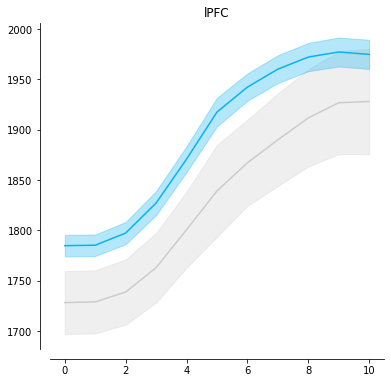

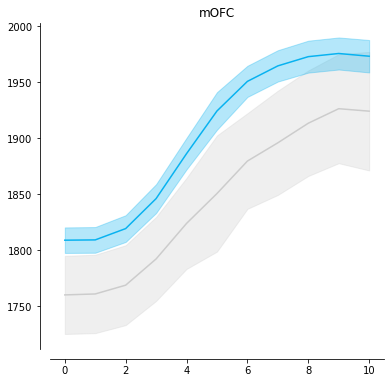

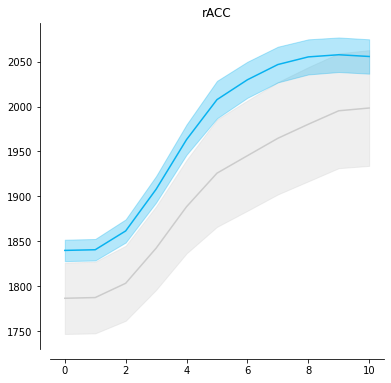

In [407]:
for ii in roi_list:
       plot_array([getattr(con_data2.groupby('level'),ii).mean().values,
              getattr(mdd_data2.groupby('level'),ii).mean().values], 
              error=[getattr(con_data2.groupby('level'),ii).sem().values,
                     getattr(mdd_data2.groupby('level'),ii).sem().values], figsize=(6,6), color=[con_color,mdd_color],
              title=ii)

In [442]:
print(getattr(mdd_data2.groupby('level'),'lPFC').std())
print(getattr(con_data2.groupby('level'),'lPFC').std())

level
0      76.469790
1      76.234677
2      78.709139
3      85.270824
4      91.729685
5     101.495219
6      96.647143
7      98.615730
8     100.197862
9     103.036441
10    103.621081
Name: lPFC, dtype: float64
level
0     103.441060
1     104.209213
2     107.468510
3     114.753095
4     125.177299
5     151.347184
6     141.727085
7     152.414252
8     159.872093
9     169.282232
10    173.946854
Name: lPFC, dtype: float64


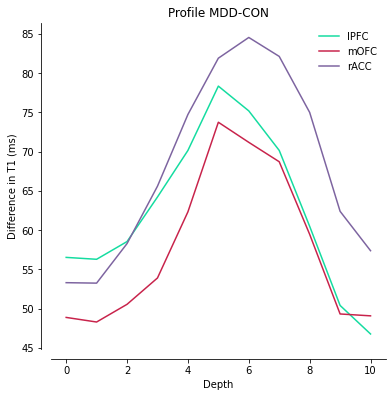

In [455]:
# correlate with DVARS/FD
color_list = [rois['ROI'][i]['color'] for i,x in enumerate(rois['ROI'])][:3]
color_list.reverse()

diff_lpfc = getattr(mdd_data2.groupby('level'),'lPFC').mean().values - getattr(con_data2.groupby('level'),'lPFC').mean().values
diff_mofc = getattr(mdd_data2.groupby('level'),'mOFC').mean().values - getattr(con_data2.groupby('level'),'mOFC').mean().values
diff_racc = getattr(mdd_data2.groupby('level'),'rACC').mean().values - getattr(con_data2.groupby('level'),'rACC').mean().values

plot_array([diff_lpfc, diff_mofc, diff_racc], figsize=(6,6), labels=['lPFC','mOFC','rACC'], title="Profile MDD-CON", y_label="Difference in T1 (ms)", x_label="Depth", color=color_list)

In [315]:
full_data.head()

,ID,PP_ID,age,Sex,Diagnostic_Status,med0,med0a,med0str,mddids,mddidssev,...,b_poly_rACC_hemi-LR_T1map,c_poly_rACC_hemi-LR_T1map,d_poly_rACC_hemi-LR_T1map,avg_rACC_hemi-LR_T2starmap,auc_rACC_hemi-LR_T2starmap,a_poly_rACC_hemi-LR_T2starmap,b_poly_rACC_hemi-LR_T2starmap,c_poly_rACC_hemi-LR_T2starmap,d_poly_rACC_hemi-LR_T2starmap,NL_idx_rACC
0,1.0,URIS_MDD_001,35.090411,Vrouw,HC,1.0,4,Yes,NaN,NaN,...,7.298491,-0.457701,1795.355726,NaN,NaN,NaN,NaN,NaN,NaN,85.552672
1,3.0,URIS_MDD_003,30.257534,man,HC,0.0,NaN,No,NaN,NaN,...,8.273341,-0.710965,1899.314934,NaN,NaN,NaN,NaN,NaN,NaN,168.577811
2,4.0,URIS_MDD_004,33.775342,Vrouw,HC,1.0,1,Yes,NaN,NaN,...,9.673544,-0.807674,1852.271103,NaN,NaN,NaN,NaN,NaN,NaN,180.434290
3,6.0,URIS_MDD_006,25.969863,Vrouw,MDD,1.0,3,Yes,40,Severe,...,6.373542,-0.602751,1821.894636,NaN,NaN,NaN,NaN,NaN,NaN,170.984938
4,7.0,URIS_MDD_007,41.791781,Vrouw,MDD,0.0,"Routing, geen medicijnen",No,32,Moderate,...,10.201000,-0.843211,1847.938908,NaN,NaN,NaN,NaN,NaN,NaN,184.414665


In [357]:
subjs = mdd_data2.reset_index()['subject'].unique()
print(subjs)
len(subjs)

['006' '007' '017' '027' '030' '037' '043' '044' '046' '047' '050' '051'
 '053' '056' '057' '059' '076' '078' '079' '080' '082' '088' '093' '096'
 '099' '102' '103' '106' '108' '110' '115' '120' '131' '136' '138' '141'
 '143' '144' '152' '153' '154' '157' '160' '164' '172' '176' '189' '202'
 '210' '224' '241']


51

In [388]:
# fetch the medicine users
mdd_clinical = full_data.loc[full_data['Diagnostic_Status'] == 'MDD']
mdd_medusers = mdd_clinical.loc[mdd_clinical['med0'] == 1]['PP_ID'].values
mdd_nousers = mdd_clinical.loc[mdd_clinical['med0'] == 0]['PP_ID'].values
med_users = [str(i).split('_')[-1] for i in mdd_medusers]
med_users = [i for i in med_users if i not in exclude_subjs]
med_nousers = [str(i).split('_')[-1] for i in mdd_nousers]
med_nousers = [i for i in med_nousers if i not in exclude_subjs]
print(f"{len(med_users)} patients are using medication")
print(f"{len(med_nousers)} patients are not using medication")

# get subjects in mdd_data2 dataframe
subjs = mdd_data2.reset_index()['subject'].unique()

# split profile data into med-users and non-users
med_yes = []
med_no = []
for sub in subjs:
    dd = mdd_data2.reset_index().loc[mdd_data2.reset_index()['subject'] == sub].set_index(['subject', 'level'])

    if sub in med_users:
        med_yes.append(dd)
    elif sub in med_nousers:
        med_no.append(dd)
    else:
        print(f"{sub} does have data, but no information on medication use is available")

med_yes = pd.concat(med_yes) #.set_index(['subject', 'level'])
med_no = pd.concat(med_no) #.set_index(['subject', 'level'])

34 patients are using medication
16 patients are not using medication
027 does have data, but no information on medication use is available


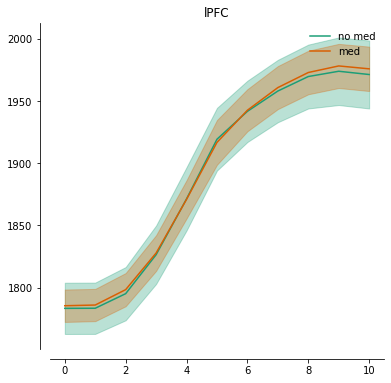

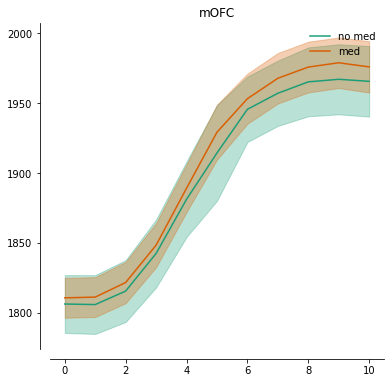

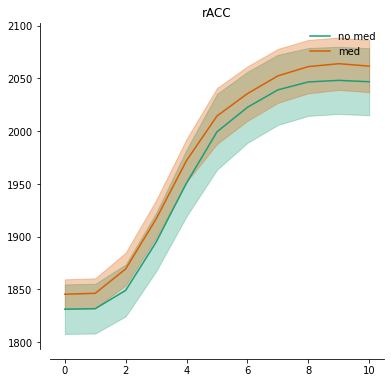

In [408]:
for ii in roi_list:
       plot_array([getattr(med_no.groupby('level'),ii).mean().values,
              getattr(med_yes.groupby('level'),ii).mean().values], 
              error=[getattr(med_no.groupby('level'),ii).sem().values,
                     getattr(med_yes.groupby('level'),ii).sem().values], figsize=(6,6), color=["#1B9E77","#D95F02"], title=ii, labels=['no med', 'med'])

In [396]:
hemi_lr = full_data.copy()
hemi_lr.drop(list(hemi_lr.filter(regex='hemi-L_')), axis=1, inplace=True)
hemi_lr.drop(list(hemi_lr.filter(regex='hemi-R_')), axis=1, inplace=True)
hemi_lr

,ID,PP_ID,age,Sex,Diagnostic_Status,med0,med0a,med0str,mddids,mddidssev,...,b_poly_rACC_hemi-LR_T1map,c_poly_rACC_hemi-LR_T1map,d_poly_rACC_hemi-LR_T1map,avg_rACC_hemi-LR_T2starmap,auc_rACC_hemi-LR_T2starmap,a_poly_rACC_hemi-LR_T2starmap,b_poly_rACC_hemi-LR_T2starmap,c_poly_rACC_hemi-LR_T2starmap,d_poly_rACC_hemi-LR_T2starmap,NL_idx_rACC
0,1.0,URIS_MDD_001,35.090411,Vrouw,HC,1.0,4,Yes,NaN,NaN,...,7.298491,-0.457701,1795.355726,NaN,NaN,NaN,NaN,NaN,NaN,85.552672
1,3.0,URIS_MDD_003,30.257534,man,HC,0.0,NaN,No,NaN,NaN,...,8.273341,-0.710965,1899.314934,NaN,NaN,NaN,NaN,NaN,NaN,168.577811
2,4.0,URIS_MDD_004,33.775342,Vrouw,HC,1.0,1,Yes,NaN,NaN,...,9.673544,-0.807674,1852.271103,NaN,NaN,NaN,NaN,NaN,NaN,180.434290
3,6.0,URIS_MDD_006,25.969863,Vrouw,MDD,1.0,3,Yes,40,Severe,...,6.373542,-0.602751,1821.894636,NaN,NaN,NaN,NaN,NaN,NaN,170.984938
4,7.0,URIS_MDD_007,41.791781,Vrouw,MDD,0.0,"Routing, geen medicijnen",No,32,Moderate,...,10.201000,-0.843211,1847.938908,NaN,NaN,NaN,NaN,NaN,NaN,184.414665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,189.0,URIS_MDD_189,54.284932,Vrouw,MDD,1.0,7,Yes,37,Moderate,...,10.320173,-0.877139,1874.838567,NaN,NaN,NaN,NaN,NaN,NaN,203.351630
69,202.0,URIS_MDD_202,27.624658,Vrouw,MDD,0.0,"Routing, geen medicijnen",No,32,Moderate,...,6.599340,-0.637687,1878.563578,NaN,NaN,NaN,NaN,NaN,NaN,187.552921
70,210.0,URIS_MDD_210,50.246575,man,MDD,0.0,"Routing, geen medicijnen",No,24,Mild,...,10.868303,-0.880678,1815.865869,NaN,NaN,NaN,NaN,NaN,NaN,184.551210
71,224.0,URIS_MDD_224,39.082192,Vrouw,MDD,1.0,2,Yes,22,Mild,...,6.870901,-0.635824,1767.934633,NaN,NaN,NaN,NaN,NaN,NaN,173.638659


In [398]:
fname = 'uris_hemi_lr_clinical.csv'
hemi_lr.to_csv(opj(proj, 'derivatives', 'statistics', fname))
print(f"{opj(proj, 'derivatives', 'statistics', fname)}")
# mdd = full_data.loc[full_data['Diagnostic_Status'] == "MDD"]
# mdd.to_csv(opj(proj, 'derivatives', 'statistics', 'uris_mdd.csv'))
# mdd.head(40)

/data1/projects/MicroFunc/Jurjen/projects/URIS-MDD/derivatives/statistics/uris_hemi_lr_clinical.csv


In [72]:
roi_list

['lPFC', 'mOFC', 'rACC']

In [80]:
col_list = [f"{hemi}_{i}" for i in roi_list for hemi in ['lh', 'rh']]
test_df = pd.DataFrame(np.squeeze(roi_data), columns=col_list)
test_df['subject'], test_df['level'] = 1, np.arange(0,11)
test_df.set_index(['subject', 'level'])

lh_lPFC      rh_lPFC      lh_mOFC      rh_mOFC  \
subject level                                                       
1       0      1768.405379  1821.530873  1826.788879  1839.407191   
        1      1768.325630  1821.054349  1827.017617  1839.518359   
        2      1780.996043  1831.166905  1837.217861  1847.768671   
        3      1813.381811  1862.211920  1863.432318  1877.498239   
        4      1863.826030  1907.542884  1908.226352  1925.745238   
        5      1917.759929  1966.662576  1960.295058  1970.788554   
        6      1935.127340  1991.458793  1973.458029  1997.864948   
        7      1952.136628  2003.488121  1991.990738  2010.753290   
        8      1966.075943  2013.725560  1994.028541  2018.401648   
        9      1972.276465  2023.178582  1994.203215  2020.948499   
        10     1968.539593  2022.075274  1990.377098  2018.656424   

                   lh_rACC      rh_rACC  
subject level                            
1       0      1827.301098  1881.629766  
        1      1827.579976  1881.166149  
        2      1848.601696  1900.472395  
        3      1893.985660  1949.195480  
        4      1946.637602  2003.014550  
        5      1997.690143  2053.930962  
        6      2022.052842  2052.286073  
        7      2033.628899  2068.030953  
        8      2032.535673  2085.271179  
        9      2037.331895  2089.391433  
        10     2038.414702  2091.083911

In [383]:
fprof = utils.get_file_from_substring("T1map.pkl", opj(proj, 'derivatives', 'statistics'))
with (open(fprof, "rb")) as openfile:
    t1_profile_data = pickle.load(openfile)

fprof = utils.get_file_from_substring("T2starmap.pkl", opj(proj, 'derivatives', 'statistics'))
with (open(fprof, "rb")) as openfile:
    t2s_profile_data = pickle.load(openfile)

t1_profile_data

{'con_avg': array([[1724.624, 1732.096, 1761.244, 1759.278, 1800.682, 1772.436],
        [1725.267, 1732.813, 1762.029, 1760.179, 1801.867, 1772.838],
        [1734.96 , 1742.724, 1770.243, 1767.669, 1818.737, 1787.759],
        [1759.678, 1766.298, 1793.387, 1791.379, 1856.86 , 1827.787],
        [1797.601, 1803.763, 1828.148, 1820.054, 1901.046, 1875.957],
        [1834.935, 1843.484, 1846.075, 1855.538, 1940.214, 1911.461],
        [1862.983, 1871.375, 1885.35 , 1874.241, 1958.061, 1932.541],
        [1889.352, 1890.679, 1897.045, 1895.162, 1975.533, 1953.806],
        [1913.978, 1909.442, 1914.57 , 1912.621, 1986.573, 1974.052],
        [1931.592, 1922.039, 1928.001, 1925.125, 1996.714, 1993.914],
        [1933.353, 1922.803, 1931.503, 1917.222, 1997.58 , 1999.194]]),
 'con_err': array([[33.576, 30.508, 35.595, 34.46 , 33.447, 47.077],
        [33.806, 30.743, 35.881, 34.364, 33.549, 47.222],
        [34.378, 32.161, 36.633, 34.991, 35.457, 49.038],
        [36.331, 34.664, 38.998,

In [83]:
color_list = [rois['ROI'][i]['color'] for i,x in enumerate(rois['ROI'])]
color_list = [i for i in color_list for hemi in ['lh', 'rh']]
color_list

['#7d64a0',
 '#7d64a0',
 '#c8234b',
 '#c8234b',
 '#14dca0',
 '#14dca0',
 '#b42878',
 '#b42878',
 '#ffc020',
 '#ffc020']

In [84]:
con_data[0,...].shape

(11, 6)

(11, 6)
161.300070317903
141.703441022604
148.562734880569
149.815093707740
140.688220521808
144.714646566396


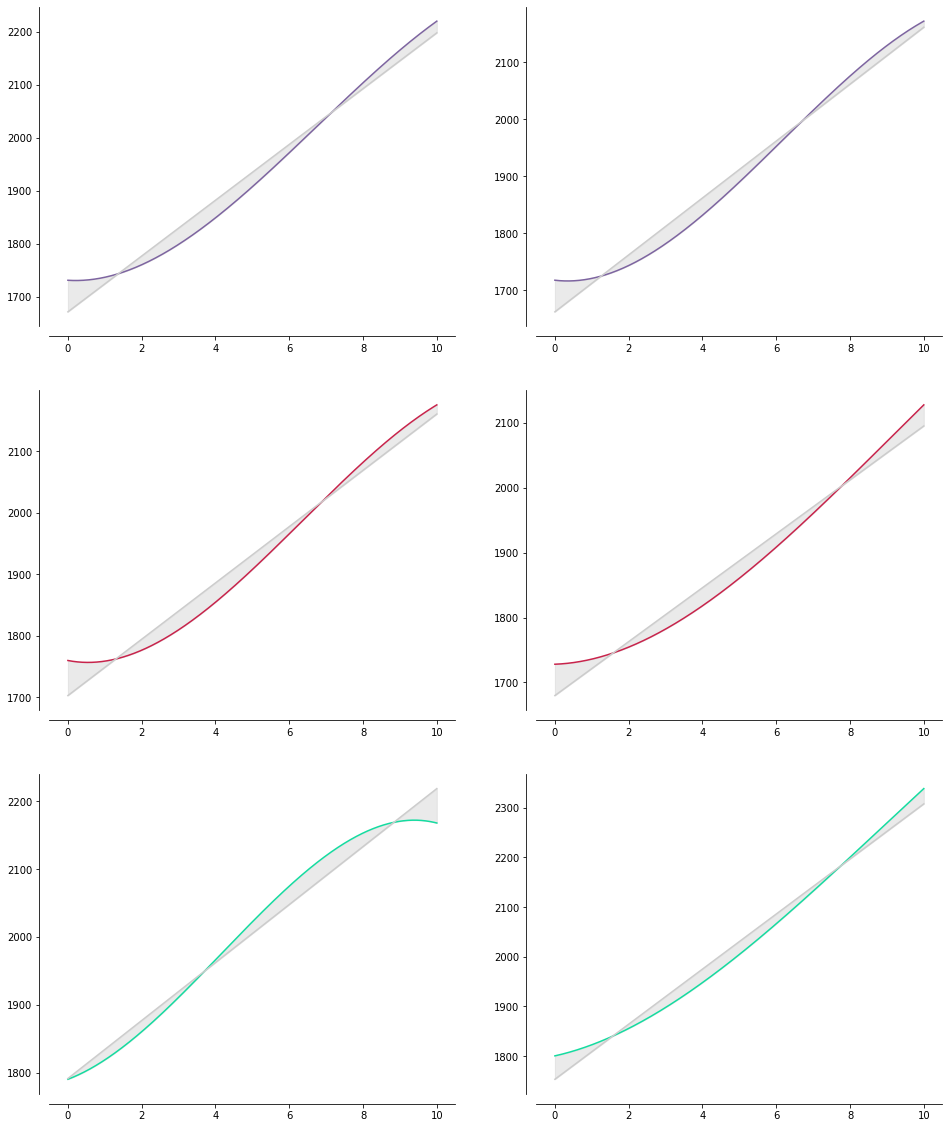

In [178]:
from scipy.optimize import curve_fit
import sympy as sy
# https://machinelearningmastery.com/curve-fitting-with-python/

fav_subj = con_data[0,...]
print(fav_subj.shape)

colors = sns.color_palette('viridis',2)

fig,axs = plt.subplots(3,2, figsize=(16,20))

# 2nd order polynomial
# def func(x, a, b, c):
# 	return a * x + b * x**2 + c
def fit_lin(x,a,b):
    return a*x + b

def fit_cubic(x, a, b, c, d):
	return (a * x) + (b * x**2) + (c * x**3) + d

for i, ax in enumerate(fig.axes):
           
    # plot fit
    xx = np.arange(0,fav_subj[...,i].shape[0])
    popt_lin, pcov_lin = curve_fit(fit_lin, xx, fav_subj[...,i])
    popt_cub, pcov_cub = curve_fit(fit_cubic, xx, fav_subj[...,i])
    
    # calculate mean-squared error and R2
    # MSE = ((yy - fav_subj[...,i]) ** 2).mean()
    # R2 = 1 - (np.sum((fav_subj[...,i] - yy) ** 2) / np.sum((fav_subj[...,i] - fav_subj[...,i].mean()) ** 2))
    
    # MSE_rois.append(MSE)
    # R2_rois.append(R2)
    
    # verts = [(0, np.amin(yy)), *zip(xx, yy), (xx.shape[0]-1, np.amin(yy))]
    # poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
    # ax.add_patch(poly)

    def f(x):
        a,b,c,d = popt_cub[0],popt_cub[1],popt_cub[2],popt_cub[3]
        return (a * x) + (b * x**2) + (c * x**3) + d

    def g(x):
        a,b = popt_lin[0],popt_lin[1]
        return a*x + b

    
    x = np.linspace(0,10,1000)
    yy_lin = fit_lin(x, *popt_lin)
    yy_cub = fit_cubic(x, *popt_cub)
    ax.plot(x, yy_cub, color=color_list[i])
    ax.plot(x, yy_lin, color="#cccccc")
    ax.fill_between(x,yy_lin, yy_cub, color="#cccccc", alpha=0.4)

    x = sy.Symbol('x')
    intersect = sy.solve(f(x) - g(x), x)
    # lin_surf = sy.integrate(g(x), (x, 0,10))
    # cub_surf = sy.integrate(f(x), (x, 0,10))
    cross_points = sy.solve(f(x)-g(x), x)

    def condition(x):
        '''Define your arbitrarily
        complicated condition here'''
        return x<10 and x>0

    area = [sy.re(x) for x in cross_points]
    # print(area)
    filtered = [x for x in area if condition(x)]
    # print(filtered)

    comb_area = 0
    x = sy.Symbol('x')
    for ix,qq in enumerate(filtered):
        if ix == 0:
            rr = [0,qq]
            # print(rr)
            comb_area += abs(sy.integrate(f(x)-g(x),(x,*rr)))
        else:
            try:
                rr = [filtered[ix-1],qq]
                comb_area += abs(sy.integrate(f(x)-g(x),(x,*rr)))
            except Exception:
                pass
        
    print(comb_area)
    
sns.despine(offset=10)

In [388]:
# # https://stackoverflow.com/questions/21285380/find-column-whose-name-contains-a-specific-string
# auc_data = full_data.filter(regex='auc')

# # https://stackoverflow.com/questions/22649693/drop-rows-with-all-zeros-in-pandas-data-frame
# auc_data = auc_data.loc[~(auc_data==0).all(axis=1)]
# auc_data

In [389]:
# g1.plot(all_data[[step], color=rois['ROI'][i]['color'])
mdd_color = "#08B2F0"
con_color = "#cccccc"

(3, 73)


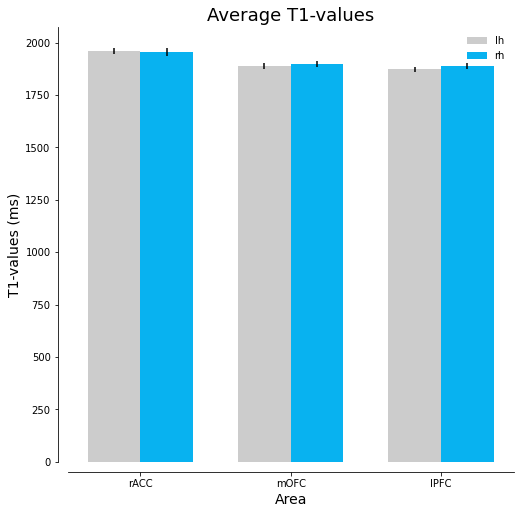

In [390]:
lh_roi = np.array([full_data[f'avg_{roi}_hemi-L_T1map'] for roi in roi_list])
rh_roi = np.array([full_data[f'avg_{roi}_hemi-R_T1map'] for roi in roi_list])

params = {"text.color" : 'k'}
plt.rcParams.update(params)

# filter out zeros
lh_roi[lh_roi == 0] = np.nan
rh_roi[rh_roi == 0] = np.nan

print(rh_roi.shape)
fig, axs = plt.subplots(figsize=(8,8))
x_axis = np.arange(0,rh_roi.shape[0])
width = 0.35       # the width of the bars

# plot avg T1
axs.set_xticks(x_axis+width/2)
axs.set_xticklabels(roi_list)
rects1 = axs.bar(x_axis, np.nanmean(lh_roi, axis=-1), width, yerr=sem(lh_roi, axis=-1, nan_policy='omit'), color=con_color, label='lh', align='center')
rects2 = axs.bar(x_axis+width, np.nanmean(rh_roi, axis=-1), width, yerr=sem(rh_roi, axis=-1, nan_policy='omit'), color=mdd_color, label='rh', align='center')
axs.set_xlabel("Area").set_fontsize(14)
axs.set_ylabel("T1-values (ms)").set_fontsize(14)
axs.set_title("Average T1-values").set_fontsize(18)
axs.legend(frameon=False)
sns.despine(offset=10)

In [391]:
# lh_roi = np.squeeze(avg.values[...,::2])
# rh_roi = np.squeeze(avg.values[...,1::2])

# fig, axs = plt.subplots(1,2, figsize=(15,6))
# x_axis = np.arange(0,rh_roi.shape[0])
# width = 0.35       # the width of the bars

# # plot avg T1
# axs[0].set_xticks(x_axis+width/2)
# axs[0].set_xticklabels(roi_list)
# rects1 = axs[0].bar(x_axis, lh_roi, width, color=con_color, label='lh', align='center')
# rects2 = axs[0].bar(x_axis+width, rh_roi, width, color=mdd_color, label='rh', align='center')
# axs[0].set_xlabel("Area").set_fontsize(14)
# axs[0].set_ylabel("T1-values (ms)").set_fontsize(14)
# axs[0].set_title("Average T1-values").set_fontsize(18)
# axs[0].legend(frameon=False)

# # plot avg AUC
# lh_roi = np.squeeze(auc_data.values[...,::2])
# rh_roi = np.squeeze(auc_data.values[...,1::2])

# axs[1].set_xticks(x_axis+width/2)
# axs[1].set_xticklabels(roi_list)
# rects1 = axs[1].bar(x_axis, lh_roi, width, color=con_color, label='lh', align='center')
# rects2 = axs[1].bar(x_axis+width, rh_roi, width, color=mdd_color, label='rh', align='center')
# axs[1].set_xlabel("Area").set_fontsize(14)
# axs[1].set_ylabel("area under the curve (a.u.)").set_fontsize(14)
# axs[1].set_title("AUC").set_fontsize(18)
# axs[1].legend(frameon=False)
# sns.despine(offset=10)

In [392]:
roi_list

['rACC', 'mOFC', 'lPFC']

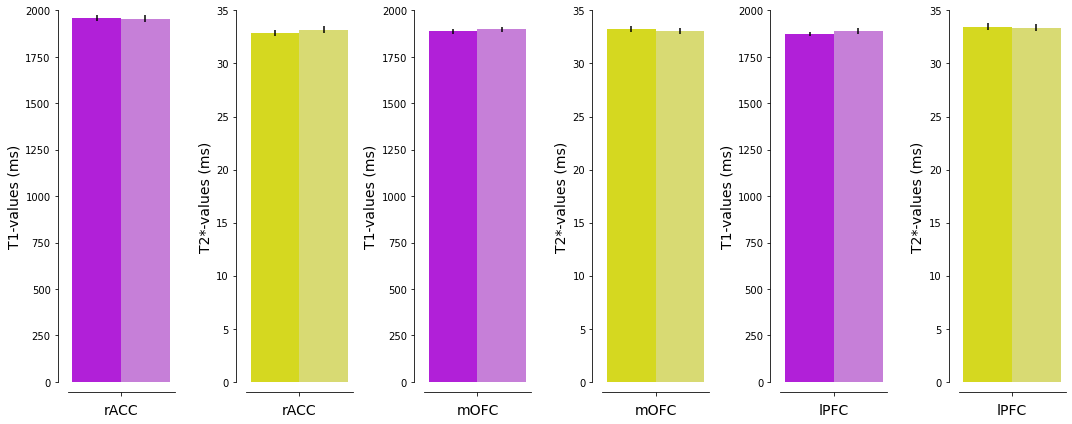

In [393]:
fig,axs = plt.subplots(1,len(roi_list*2), figsize=(15,6))
width = 0.1     # the width of the bars

# plot avg T1
plot = 0

for roi in roi_list:

    for ii in ['T1map','T2starmap']:

        if ii == "T1map":
            x_tag = "T1-values (ms)"
            lh_col = "#B120D8"
            rh_col = "#C67FD8"
            y_bounds = [0,2000]
        elif ii == "T2starmap":
            x_tag = "T2*-values (ms)"
            lh_col = "#D5D820"
            rh_col = "#D8DA73"
            y_bounds = [0,35]

        lh_roi = full_data[f'avg_{roi}_hemi-L_{ii}'].values
        rh_roi = full_data[f'avg_{roi}_hemi-R_{ii}'].values

        x_axis = np.arange(1)

        # filter out zeros
        lh_roi[lh_roi == 0] = np.nan
        rh_roi[rh_roi == 0] = np.nan

        axs[plot].set_xticks(x_axis+width/2)
        axs[plot].set_xticklabels([])
        rects1 = axs[plot].bar(x_axis, np.nanmean(lh_roi, axis=-1), width, yerr=sem(lh_roi, axis=-1, nan_policy='omit'), color=lh_col, label='lh', align='center')
        rects2 = axs[plot].bar(x_axis+width, np.nanmean(rh_roi, axis=-1), width, yerr=sem(rh_roi, axis=-1, nan_policy='omit'), color=rh_col, label='rh', align='center')
        axs[plot].set_xlabel(roi).set_fontsize(14)
        axs[plot].set_ylabel(x_tag).set_fontsize(14)
        axs[plot].set_ylim(y_bounds)
        # axs[plot].set_title("Average T1-values").set_fontsize(18)
        # axs[plot].legend(frameon=False)
        sns.despine(offset=10)

        plot += 1

    # plot += 1
    plt.tight_layout()

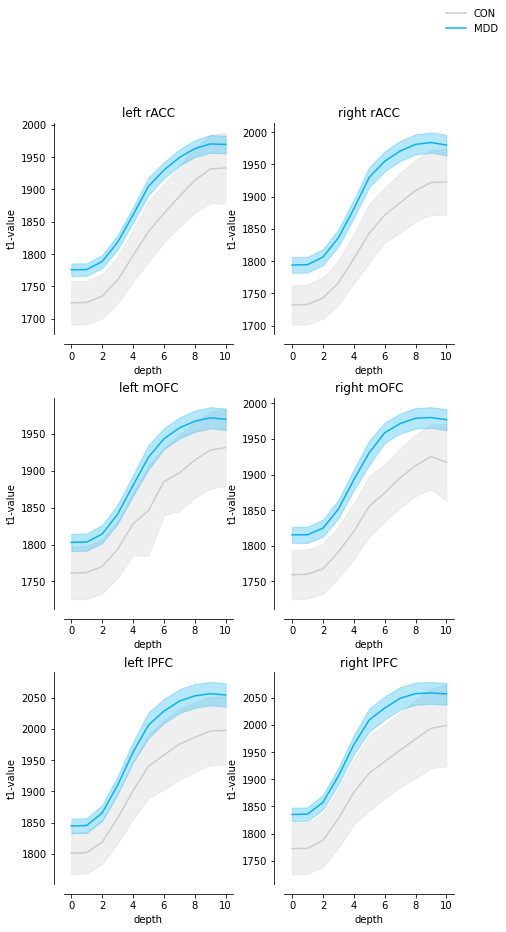

In [394]:
fig = plt.figure(figsize=(7,14))
gs1 = gridspec.GridSpec(len(roi_list),2)
gs1.update(hspace=0.3, wspace=0.3)
x_axis = np.arange(0,11)

# import random
# random_list = random.sample(range(0,50),11)

step = 0
for i,r in enumerate(roi_list):

    if step == 0:
        g1 = fig.add_subplot(gs1[step])
    else:
        g1 = fig.add_subplot(gs1[step], sharex=g1)
    
    errorfill(x_axis,t1_profile_data['con_avg'][...,step],t1_profile_data['con_err'][...,step], color=con_color)
    errorfill(x_axis,t1_profile_data['mdd_avg'][...,step],t1_profile_data['mdd_err'][...,step], color=mdd_color)
    g1.set_xticks(np.arange(0,11, step=2))
    format_graph("depth","t1-value",title=f"left {r}")
    sns.despine(offset=10)

    step += 1
    g2 = fig.add_subplot(gs1[step], sharex=g1)

    errorfill(x_axis,t1_profile_data['con_avg'][...,step],t1_profile_data['con_err'][...,step], color=con_color)
    errorfill(x_axis,t1_profile_data['mdd_avg'][...,step],t1_profile_data['mdd_err'][...,step], color=mdd_color)
    g2.set_xticks(np.arange(0,11, step=2))
    format_graph("depth","t1-value",title=f"right {r}")

    sns.despine(offset=10)

    step += 1

fig.legend(labels=['CON','MDD'], frameon=False)
plt.show()

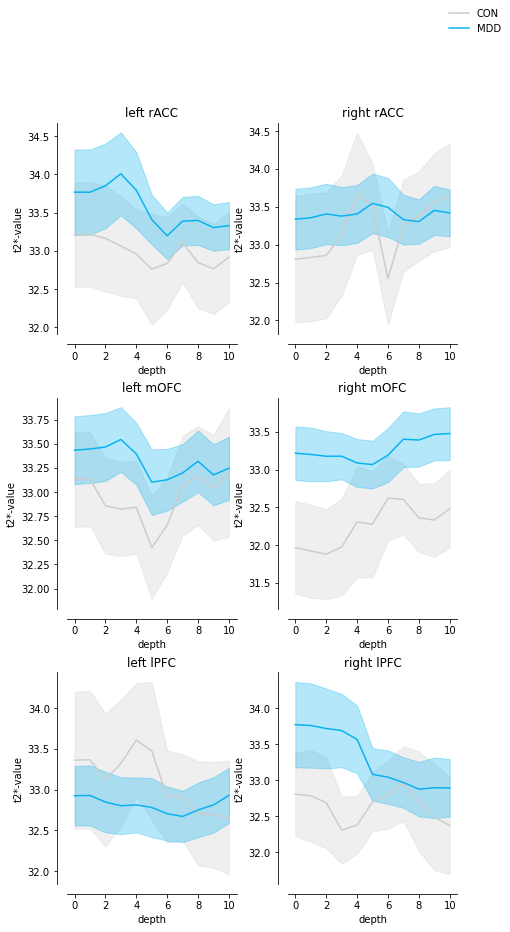

In [395]:
fig = plt.figure(figsize=(7,14))
gs1 = gridspec.GridSpec(len(roi_list),2)
gs1.update(hspace=0.3, wspace=0.3)
x_axis = np.arange(0,11)

# import random
# random_list = random.sample(range(0,50),11)

step = 0
for i,r in enumerate(roi_list):

    if step == 0:
        g1 = fig.add_subplot(gs1[step])
    else:
        g1 = fig.add_subplot(gs1[step], sharex=g1)
    
    errorfill(x_axis,t2s_profile_data['con_avg'][...,step],t2s_profile_data['con_err'][...,step], color=con_color)
    errorfill(x_axis,t2s_profile_data['mdd_avg'][...,step],t2s_profile_data['mdd_err'][...,step], color=mdd_color)
    g1.set_xticks(np.arange(0,11, step=2))
    format_graph("depth","t2*-value",title=f"left {r}")
    sns.despine(offset=10)

    step += 1
    g2 = fig.add_subplot(gs1[step], sharex=g1)

    errorfill(x_axis,t2s_profile_data['con_avg'][...,step],t2s_profile_data['con_err'][...,step], color=con_color)
    errorfill(x_axis,t2s_profile_data['mdd_avg'][...,step],t2s_profile_data['mdd_err'][...,step], color=mdd_color)
    g2.set_xticks(np.arange(0,11, step=2))
    format_graph("depth","t2*-value",title=f"right {r}")

    sns.despine(offset=10)

    step += 1

fig.legend(labels=['CON','MDD'], frameon=False)
plt.show()

In [396]:
chunked_con_avg_t1 = list(divide_chunks(t1_profile_data['con_avg'].T, 2))
chunked_con_err_t1 = list(divide_chunks(t1_profile_data['con_err'].T, 2))
chunked_mdd_avg_t1 = list(divide_chunks(t1_profile_data['mdd_avg'].T, 2))
chunked_mdd_err_t1 = list(divide_chunks(t1_profile_data['mdd_err'].T, 2))

chunked_con_avg_t2 = list(divide_chunks(t2s_profile_data['con_avg'].T, 2))
chunked_con_err_t2 = list(divide_chunks(t2s_profile_data['con_err'].T, 2))
chunked_mdd_avg_t2 = list(divide_chunks(t2s_profile_data['mdd_avg'].T, 2))
chunked_mdd_err_t2 = list(divide_chunks(t2s_profile_data['mdd_err'].T, 2))

In [397]:
chunked_con_avg_t1[0].shape

(2, 11)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


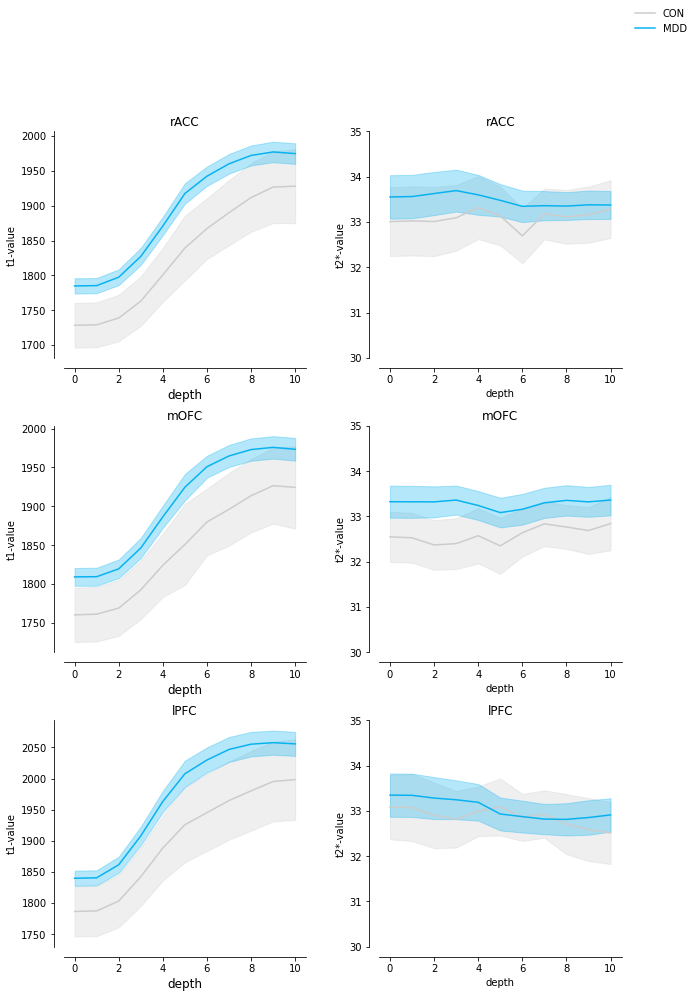

In [404]:
fig = plt.figure(figsize=(10,15))
gs1 = gridspec.GridSpec(len(roi_list),2)
gs1.update(hspace=0.3, wspace=0.3)
x_axis = np.arange(0,11)

# import random
# random_list = random.sample(range(0,50),11)

step = 0
for i,r in enumerate(roi_list):

    if step == 0:
        g1 = fig.add_subplot(gs1[step])
    else:
        g1 = fig.add_subplot(gs1[step], sharex=g1)
    
    
    errorfill(x_axis,chunked_con_avg_t1[i].mean(axis=0), chunked_con_err_t1[i].mean(axis=0), color=con_color)
    errorfill(x_axis,chunked_mdd_avg_t1[i].mean(axis=0), chunked_mdd_err_t1[i].mean(axis=0), color=mdd_color)
    g1.set_xticks(np.arange(0,11, step=2))
    format_graph("depth","t1-value",title=f"{r}")
    g1.set_xlabel("depth", fontname='Arial').set_fontsize(12)
    sns.despine(offset=10)

    step += 1

    g2 = fig.add_subplot(gs1[step], sharex=g1)
    errorfill(x_axis,chunked_con_avg_t2[i].mean(axis=0), chunked_con_err_t2[i].mean(axis=0), color=con_color)
    errorfill(x_axis,chunked_mdd_avg_t2[i].mean(axis=0), chunked_mdd_err_t2[i].mean(axis=0), color=mdd_color)
    g2.set_xticks(np.arange(0,11, step=2))
    format_graph("depth","t2*-value",title=f"{r}")
    g2.set_ylim([30,35])
    sns.despine(offset=10)

    step += 1

fig.legend(labels=['CON','MDD'], frameon=False)
fig.savefig(opj(proj, 'code', 'figures', 'fig2', 'uris_profiles.svg'), dpi=300)
plt.show()

In [420]:
diff = chunked_mdd_avg_t1[i].mean(axis=0) - chunked_con_avg_t1[i].mean(axis=0)
glm.plot_array(diff, figsize=(6,6))

NameError: name 'chunked_mdd_avg_t1' is not defined

In [226]:
chunked_con_avg_t1[0].shape

(2, 11)

In [243]:
len(roi_list)

3

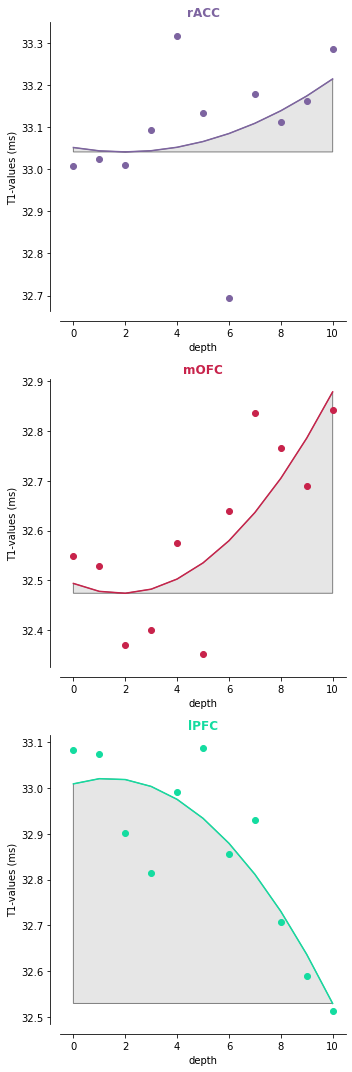

In [247]:
from scipy.optimize import curve_fit
# https://machinelearningmastery.com/curve-fitting-with-python/

# fav_subj = con_data[0,...]
fav_subj = chunked_con_avg_t2.copy()
# print(fav_subj.shape)

colors = color_list[::2]

fig,axs = plt.subplots(3,1, figsize=(5,15))

# fit
# def func(x, a, b, c, d, e, f):
# 	return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f

# linear
# def func(x, a, b):
# 	return a * x + b

# Average MSE = 1833.22
# Average R2 =  0.91

# 2nd order polynomial
def func(x, a, b, c):
	return a * x + b * x**2 + c

# Average MSE = 154.01
# Average R2 =  0.99

# # # 3rd order polynomial
# def func(x, a, b, c, d):
# 	return (a * x) + (b * x**2) + (c * x**3) + d

# Average MSE = 135.35
# Average R2 =  0.99

MSE_rois = []
R2_rois = []
for i, ax in enumerate(fig.axes):

    avg_roi = fav_subj[i].mean(axis=0)
        
    ax.plot(avg_roi, 'o', color=colors[i])
    params = {"text.color" : colors[i]}
    plt.rcParams.update(params)
    
    # plot fit
    xx = np.arange(0,avg_roi.shape[0])
    popt, pcov = curve_fit(func, xx, avg_roi)
    
    yy = func(xx, *popt)
    ax.plot(xx, yy, color=colors[i])
    
    # calculate mean-squared error and R2
    MSE = ((yy - avg_roi) ** 2).mean()
    R2 = 1 - (np.sum((avg_roi - yy) ** 2) / np.sum((avg_roi - avg_roi.mean()) ** 2))
    
    MSE_rois.append(MSE)
    R2_rois.append(R2)
    
    verts = [(0, np.amin(yy)), *zip(xx, yy), (xx.shape[0]-1, np.amin(yy))]
    poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
    ax.add_patch(poly)

    ax.set_title(roi_list[i], color=colors[i], fontweight="bold")
    ax.set_xlabel("depth")
    ax.set_ylabel("T1-values (ms)")
    
sns.despine(offset=10)
plt.tight_layout()

In [64]:
avg_MSE = np.mean(MSE_rois)
avg_R2 = np.mean(R2_rois)

print(f"Average MSE = {round(avg_MSE,2)}")
print(f"Average R2 =  {round(avg_R2,2)}")

Average MSE = 154.01
Average R2 =  0.99


In [65]:
roi_list

['rACC', 'mOFC', 'lPFC']

In [66]:
all_data['con_avg'].shape

(11, 6)

(11,)


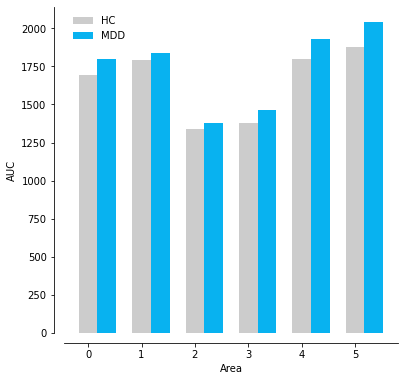

In [291]:
depth = np.arange(0,11)
print(depth.shape)

from sklearn.metrics import auc

con_area = []
mdd_area = []
for ii in range(len(roi_list)*2):

    area = auc(depth, all_data['con_avg'][...,ii]-np.amin(all_data['con_avg'][...,ii]))
    con_area.append(area)

    area = auc(depth, all_data['mdd_avg'][...,ii]-np.amin(all_data['mdd_avg'][...,ii]))
    mdd_area.append(area)

fig, axs = plt.subplots(figsize=(6,6))
x_axis = np.arange(0,len(con_area))
width = 0.35       # the width of the bars
rects1 = axs.bar(x_axis, con_area, width, color=con_color, label='HC')
rects2 = axs.bar(x_axis+width, mdd_area, width, color=mdd_color, label='MDD')
axs.set_xlabel("Area")
axs.set_ylabel("AUC")
axs.set_xticks(x_axis)
axs.legend(frameon=False)
sns.despine(offset=10)


In [26]:
rois['ROI']

[{'roi_name': 'ACC',
  'left': [1002, 1026],
  'right': [2002, 2026],
  'color': '#7d64a0'},
 {'roi_name': 'OFC', 'left': [1014], 'right': [2014], 'color': '#c8234b'},
 {'roi_name': 'dmPFC', 'left': [1028], 'right': [2028], 'color': '#14dca0'}]

0.9976163635114633


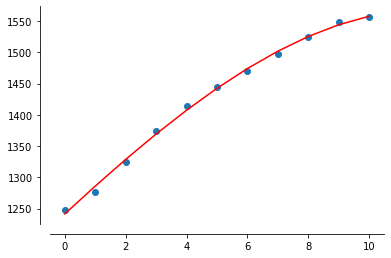

In [105]:
x = np.arange(0,11)
y = all_data['mdd_avg'][:,0]
plt.scatter(x,y)

model = np.polyfit(x, y, 3)
predict = np.poly1d(model)

from sklearn.metrics import r2_score
print(r2_score(y,predict(x)))

y_reg = predict(x)
plt.plot(x,y_reg, c='r')
sns.despine(offset=10)
plt.show()

In [28]:
all_data

{'con_avg': array([[1192.601, 1227.385, 1094.959, 1104.288, 1094.993, 1106.613],
        [1228.279, 1262.183, 1116.165, 1125.43 , 1119.79 , 1132.966],
        [1282.09 , 1317.935, 1153.001, 1163.001, 1160.507, 1176.011],
        [1332.91 , 1371.68 , 1189.57 , 1201.954, 1199.292, 1217.669],
        [1371.199, 1412.175, 1218.589, 1231.953, 1227.247, 1248.675],
        [1398.935, 1444.295, 1241.011, 1254.352, 1248.917, 1273.018],
        [1425.125, 1471.403, 1260.036, 1273.723, 1269.636, 1296.026],
        [1448.181, 1494.056, 1279.938, 1293.722, 1292.006, 1321.232],
        [1470.469, 1516.039, 1300.983, 1317.045, 1317.949, 1350.486],
        [1491.937, 1534.842, 1319.159, 1336.581, 1341.273, 1378.03 ],
        [1502.933, 1541.458, 1324.04 , 1342.946, 1351.825, 1391.26 ]]),
 'con_err': array([[ 99.296,  95.784,  96.256, 106.95 , 114.09 , 115.97 ],
        [104.755, 100.851,  99.376, 109.964, 117.447, 119.763],
        [112.847, 109.092, 104.923, 115.173, 123.068, 126.049],
        [119.5

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -2.3187      0.778     -2.982      0.015      -4.078      -0.560
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -1.8888      0.525     -3.598      0.006      -3.076      -0.701
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.4119      0.451     -0.913      0.385      -1.433       0.609
                             Test for Constraints   

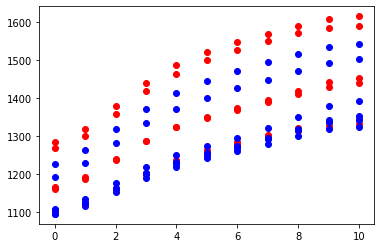

In [36]:
import statsmodels.api as sm

for roi in range(all_data['mdd_avg'].shape[-1]):

    x = np.arange(0,11)
    y1 = all_data['mdd_avg'][:,roi]
    y2 = all_data['con_avg'][:,roi]

    plt.scatter(x,y1, c='r')
    plt.scatter(x,y2, c='b')

    y = y2-y1
    mod = sm.OLS(y, sm.add_constant(x))
    res = mod.fit()

    print(res.t_test([0,1]))
    # model = np.polyfit(x, y, 1)
    # predict = np.poly1d(model)

    # from sklearn.metrics import r2_score
    # r2_score(y,predict(x))

    # y_reg = predict(x)
    # plt.plot(x,y_reg, c='r')

## Subcortical nuclei volumes

In [24]:
roi_subctx = np.loadtxt(opj(proj, 'roi_subcortex.txt'), dtype=str)
print(len(roi_subctx))

roi_subctx

26


array(['Str-l', 'Str-r', 'STN-l', 'STN-r', 'SN-l', 'SN-r', 'RN-l', 'RN-r',
       'GPi-l', 'GPi-r', 'GPe-l', 'GPe-r', 'Tha-l', 'Tha-r', 'Amg-l',
       'Amg-r', 'ic-l', 'ic-r', 'VTA-l', 'VTA-r', 'PAG-l', 'PAG-r',
       'PPN-l', 'PPN-r', 'Cl-l', 'Cl-r'], dtype='<U5')

In [25]:
sub = 'sub-999'
massp_file = utils.get_file_from_substring("volume_table", opj(nighres_dir, sub, 'ses-1', 'massp'))

with open(massp_file) as mf:    
    data = json.load(mf)
data


{'Str-l': 8199.415587037802,
 'Str-r': 8202.845587283373,
 'STN-l': 83.0060059428215,
 'STN-r': 116.96300837397575,
 'SN-l': 512.0990366637707,
 'SN-r': 491.51903519034386,
 'RN-l': 235.9840168952942,
 'RN-r': 247.64601773023605,
 'GPi-l': 570.7520408630371,
 'GPi-r': 515.8720369338989,
 'GPe-l': 1097.9430786073208,
 'GPe-r': 1167.2290835678577,
 'Tha-l': 6389.061457425356,
 'Tha-r': 6036.114432156086,
 'LV-l': 7450.98953345418,
 'LV-r': 7065.800505876541,
 '3V': 1786.0011278688908,
 '4V': 1252.9790897071362,
 'Amg-l': 1155.5670827329159,
 'Amg-r': 1049.5800751447678,
 'ic-l': 3593.2682572603226,
 'ic-r': 3582.292256474495,
 'VTA-l': 204.42801463603973,
 'VTA-r': 250.73301795125008,
 'fx': 1485.5331063568592,
 'PAG-l': 188.6500135064125,
 'PAG-r': 204.08501461148262,
 'PPN-l': 140.28701004385948,
 'PPN-r': 166.69801193475723,
 'Cl-l': 732.9910524785519,
 'Cl-r': 716.1840512752533}

In [26]:
con_arr = []
mdd_arr = []

for num,sub in enumerate(subj_list['participant_id'].values):

    ID = sub.split('-')[-1]
    DIAG = demo_info['Diagnostic_Status'][float(ID)].upper()

    tmp_arr = []
    for rr in roi_subctx:

        massp_file = utils.get_file_from_substring("volume_table", opj(nighres_dir, sub, 'ses-1', 'massp'))
        with open(massp_file) as mf:
            data = json.load(mf)
        
        tmp_arr.append(data[rr])
    tmp_arr = np.array(tmp_arr)[...,np.newaxis]

    # get group membership
    if DIAG == "MDD":
        mdd_arr.append(tmp_arr)
    elif DIAG == "HC":
        con_arr.append(tmp_arr)

if mdd_arr:
    mdd_data = np.concatenate(mdd_arr, axis=1)

if con_arr:
    con_data = np.concatenate(con_arr, axis=1)

In [27]:
all_data = {"con_avg": np.mean(con_data, axis=1),
            "con_err": np.nan_to_num(sem(con_data, axis=1)),
            "mdd_avg": np.mean(mdd_data, axis=1),
            "mdd_err": np.nan_to_num(sem(mdd_data, axis=1))}

print(all_data)

{'con_avg': array([9919.046, 9896.898,  106.257,  111.451,  574.378,  561.075,
        249.263,  240.566,  573.986,  537.555, 1291.542, 1318.517,
       7062.591, 6709.668, 1300.656, 1212.162, 3812.813, 3948.347,
        255.094,  258.475,  219.52 ,  235.421,  172.946,  198.622,
        846.745,  727.479]), 'con_err': array([392.239, 371.85 ,   4.465,   5.895,  24.079,  24.47 ,  13.539,
         9.29 ,  21.059,  21.371,  54.018,  47.653, 294.507, 268.234,
        58.506,  53.958, 137.307, 140.132,   9.559,   8.424,  10.854,
         9.825,   7.176,  10.416,  31.425,  32.789]), 'mdd_avg': array([10099.85 , 10059.388,   105.993,   114.427,   551.324,   540.978,
         252.27 ,   239.439,   559.825,   531.215,  1295.321,  1316.305,
        7009.126,  6704.229,  1257.285,  1192.452,  3945.584,  3990.627,
         255.063,   268.716,   234.   ,   240.112,   165.834,   194.971,
         839.689,   737.903]), 'mdd_err': array([120.832, 126.779,   2.34 ,   2.772,   9.569,   9.854,   4.541,
 

In [28]:
print(all_data['con_avg'])
print(all_data['mdd_avg'])

[9919.046 9896.898  106.257  111.451  574.378  561.075  249.263  240.566
  573.986  537.555 1291.542 1318.517 7062.591 6709.668 1300.656 1212.162
 3812.813 3948.347  255.094  258.475  219.52   235.421  172.946  198.622
  846.745  727.479]
[10099.85  10059.388   105.993   114.427   551.324   540.978   252.27
   239.439   559.825   531.215  1295.321  1316.305  7009.126  6704.229
  1257.285  1192.452  3945.584  3990.627   255.063   268.716   234.
   240.112   165.834   194.971   839.689   737.903]


ipykernel_launcher:40: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
ipykernel_launcher:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


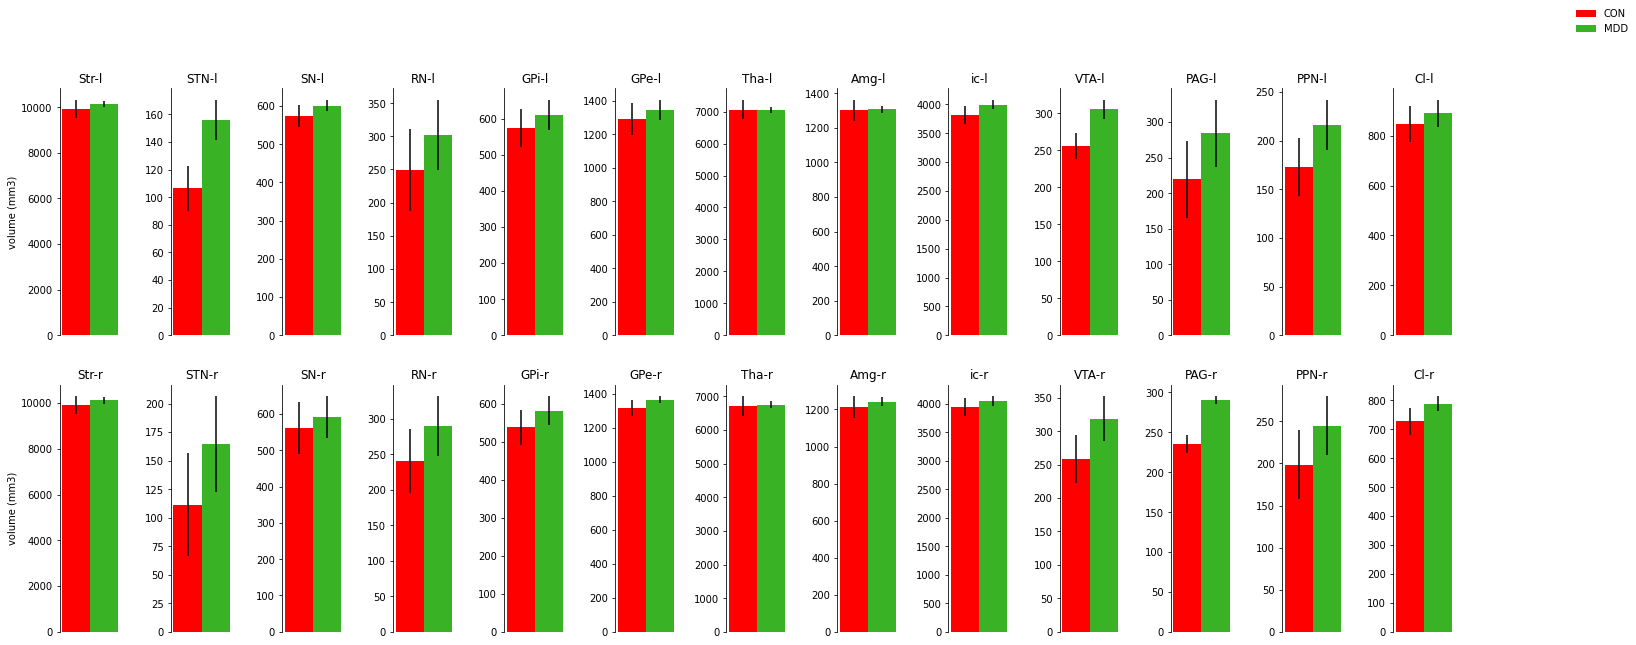

In [29]:
fig = plt.figure(figsize=(25,10))
gs1 = gridspec.GridSpec(2,int(len(roi_subctx)/2))
gs1.update(wspace=0.8)
# gs1.update(hspace=0.2)
x_axis = np.arange(0,11)

import random
random_list = random.sample(range(0,50),26)
step = 0
width = 15  # the width of the bars
for qq in np.arange(0,int(len(roi_subctx)/2),1):

    g1 = fig.add_subplot(gs1[0,qq])

    # g1.plot(all_data[[step], color=rois['ROI'][i]['color']
    g1.bar(0-width/2, all_data['con_avg'][step], width, yerr=all_data['con_err'][step]+random_list[step], label='CON', color="#FF0000")
    g1.bar(0+width/2, all_data['mdd_avg'][step]+50, width, yerr=all_data['mdd_err'][step]+random_list[step], label='MDD', color="#39B325")
    g1.set_xticks([])

    if qq == 0:
        format_graph("","volume (mm3)",title=roi_subctx[step])
    else:
        format_graph("","",title=roi_subctx[step])

    g1.spines['bottom'].set_visible(False)

    g2 = fig.add_subplot(gs1[1,qq], sharex=g1)
    step += 2
    g2.bar(0-width/2, all_data['con_avg'][step-1], width, yerr=all_data['con_err'][step-1]+random_list[step-1], label='CON', color="#FF0000")
    g2.bar(0+width/2, all_data['mdd_avg'][step-1]+50, width, yerr=all_data['mdd_err'][step-1]+random_list[step-1], label='MDD', color="#39B325")
    g2.set_xticks([])

    if qq == 0:
        format_graph("","volume (mm3)",title=roi_subctx[step-1])
    else:
        format_graph("","",title=roi_subctx[step-1])
    
    g2.spines['bottom'].set_visible(False)

fig.legend(labels=['CON','MDD'], frameon=False, loc='best')
plt.tight_layout()

In [30]:
# do simple t-test for each region
from scipy import stats

stats_output = []
cols = ['ROI', 'mean_con', 'mean_mdd', 'std', 't', 'p']

for roi in np.arange(0,con_data.shape[0]):
    
    N = con_data.shape[-1]

    var_a = con_data[roi,:].var(ddof=1)
    var_b = mdd_data[roi,:].var(ddof=1)

    s = np.sqrt((var_a + var_b)/2)

    t = (con_data[roi,:].mean() - mdd_data[roi,:].mean())/(s*np.sqrt(2/N))
    df = 2*N - 2
    p = 1 - stats.t.cdf(t,df=df)

    stats_output.append([roi_subctx[roi], float(con_data[roi,:].mean()), mdd_data[roi,:].mean(), s, t, p])

stats_df                = pd.DataFrame(np.array(stats_output), columns=cols)
stats_df['mean_con']    = pd.to_numeric(stats_df['mean_con'], downcast="float")
stats_df['mean_mdd']    = pd.to_numeric(stats_df['mean_mdd'], downcast="float")
stats_df['std']         = pd.to_numeric(stats_df['std'], downcast="float")
stats_df['t']           = pd.to_numeric(stats_df['t'], downcast="float")
stats_df['p']           = pd.to_numeric(stats_df['p'], downcast="float")

stats_df

,ROI,mean_con,mean_mdd,std,t,p
0,Str-l,9919.045898,10099.849609,1218.922729,-0.392446,0.651036
1,Str-r,9896.897461,10059.387695,1190.774780,-0.361032,0.639504
2,STN-l,106.256500,105.993126,17.113258,0.040719,0.483916
3,STN-r,111.450500,114.427254,21.411444,-0.367828,0.642011
4,SN-l,574.377991,551.323486,81.376907,0.749555,0.230126
5,SN-r,561.074524,540.978394,83.127388,0.639613,0.264010
6,RN-l,249.263000,252.270386,43.135681,-0.184459,0.572458
7,RN-r,240.565506,239.438507,39.983833,0.074574,0.470562
8,GPi-l,573.986023,559.825012,75.885368,0.493725,0.312823
9,GPi-r,537.554504,531.215149,88.302032,0.189944,0.425414
